## 信用卡评分

###  背景

+ 银行在市场经济中起到至关重要的作用。他们决定谁在什么条件下可以得到融资，并且可以创造或打破投资决策。而市场、社会，以及个人和企业都需要获得贷款。

+ 信用评分算法，对默认可能性进行猜测，这是银行用来判断贷款是否应该被授予的方法。

+ 首先是基于个人借贷的场景，确定“违约”的定义： 根据新的**Basel II Capital Accord（巴塞尔二资本协议）**，一般逾期**90**天算作违约。

+ 在判别指标上，选择使用历史最大违约天数。

**目标**：完成一个评分卡，通过预测某人在未来两年内将会经历财务危机的可能性来提高信用评分的效果，帮助贷款人做出最好的决策。

典型的信用评分模型模型的主要开发流程如下：
1. 数据获取，包括获取存量客户及潜在客户的数据。存量客户是指已经在证券公司开展相关融资类业务的客户，包括个人客户和机构客户；潜在客户是指未来拟在证券公司开展相关融资类业务的客户，主要包括机构客户，这也是解决证券业样本较少的常用方法，这些潜在机构客户包括上市公司、公开发行债券的发债主体、新三板上市公司、区域股权交易中心挂牌公司、非标融资机构等；
2. 数据预处理，主要工作包括数据清洗、缺失值处理、异常值处理，主要是为了将获取的原始数据转化为可用作模型开发的格式化数据；
3. 探索性数据分析，该步骤主要是获取样本总体的大概情况，描述样本总体情况的指标主要有直方图、箱形图等；
4. 变量选择，该步骤主要是通过统计学的方法，筛选出对违约状态影响最显著的指标。主要有单变量特征选择方法和基于机器学习模型的方法 ；
5. 模型开发，该步骤主要包括变量分段、变量的WOE（证据权重）变换和逻辑回归估算三部分；
6. 模型评估，该步骤主要是评估模型的区分能力、预测能力、稳定性，并形成模型评估报告，得出模型是否可以使用的结论；
7. 信用评分，根据逻辑回归的系数和WOE等确定信用评分的方法。将Logistic模型转换为标准评分的形式；
8. 建立评分系统，根据信用评分方法，建立自动信用评分系统。

### 1|数据获取

数据来源：数据来自Kaggle比赛平台[GiveMeSomeCredit](https://www.kaggle.com/c/GiveMeSomeCredit)，其中cs-training.csv是有15万条的样本数据，下图可以看到这份数据的大致情况。

+ 数据描述

    + 数据属于个人消费类贷款，只考虑评分卡最终实施时能够使用到的数据应从如下一些方面获取数据：

      - 基本属性：包括了借款人当时的年龄。

      - 偿债能力：包括了借款人的月收入、负债比率。

      - 信用往来：两年内35-59天逾期次数、两年内60-89天逾期次数、两年内90天或高于90天逾期的次数。

      - 财产状况：包括了开放式信贷和贷款数量、不动产贷款或额度数量。

      - 贷款属性：暂无。

      - 其他因素：包括了借款人的家属数量（不包括本人在内）。
      - 时间窗口：自变量的观察窗口为过去两年，因变量表现窗口为未来两年。

+ 原始变量

|标号|变量名 | 变量类型 | 变量描述|
| ---- |---- | ---- | ----|
| Res |SeriousDlqin2yrs | Y/N | 好客户或坏客户|
|x1|RevolvingUtilizationOf UnsecuredLines | percentage | 无担保放款的循环利用|
|x2|age | integer  | 借款人当时的年龄|
|x3|NumberOfTime30-59DaysPastDueNotWorse | integer | 35-59天逾期但不糟糕次数|
|x4|DebtRatio | percentage | 负债比率|
|x5|MonthlyIncome | real | 月收入|
|x6|NumberOf OpenCreditLinesAndLoans | integer|开放式贷款（分期付款如汽车贷款或抵押贷款）和信贷（如信用卡）的数量|
|x7|NumberOfTimes90DaysLate | integer |90天逾期次数：借款者有90天或更高逾期的次数|
|x8|NumberRealEstateLoans OrLines | integer | 不动产贷款或额度数量|
|x9|NumberOfTime60-89DaysPastDueNotWorse | integer | 60-89天逾期但不糟糕次数|
|x10|NumberOfDependents | integer | 家属数量：不包括本人在内的家属数量|

### 2|数据预处理

在对数据处理之前，需要对数据的缺失值和异常值情况进行了解。

In [1]:
# 导入所需包
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

sns.set()
%matplotlib inline

In [2]:
data = pd.read_csv('data/cs-training.csv')
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
data = data.drop('Unnamed: 0', axis=1)
data.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

从上图可知，变量MonthlyIncome和NumberOfDependents存在缺失，变量MonthlyIncome共有缺失值29731个，NumberOfDependents有3924个缺失值。

#### 缺失值处理

这种情况在现实问题中非常普遍，这会导致一些不能处理缺失值的分析方法无法应用，因此，在信用风险评级模型开发的第一步我们就要进行缺失值处理。缺失值处理的方法，包括如下几种：
1. 直接删除含有缺失值的样本。
2. 根据样本之间的相似性填补缺失值。
3. 根据变量之间的相关关系填补缺失值。
变量MonthlyIncome缺失率比较大，所以我们根据变量之间的根据样本之间的相似性填补缺失值，我们采用KNN最近邻算法：

In [4]:
# 标签替换
cleanCol = []
for i in range(len(data.columns)):
    cleanCol.append(data.columns[i].replace('-', ''))
    
data.columns = cleanCol
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime3059DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime6089DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [5]:
#knn 填充 
from sklearn.neighbors import KNeighborsRegressor

incomeImputer = KNeighborsRegressor(n_neighbors=3)

In [6]:
data[data.MonthlyIncome.isnull() == False].corr().iloc[:, 5]

SeriousDlqin2yrs                       -0.019746
RevolvingUtilizationOfUnsecuredLines    0.007124
age                                     0.037717
NumberOfTime3059DaysPastDueNotWorse    -0.010217
DebtRatio                              -0.028712
MonthlyIncome                           1.000000
NumberOfOpenCreditLinesAndLoans         0.091455
NumberOfTimes90DaysLate                -0.012743
NumberRealEstateLoansOrLines            0.124959
NumberOfTime6089DaysPastDueNotWorse    -0.011116
NumberOfDependents                      0.062647
Name: MonthlyIncome, dtype: float64

In [7]:
# 使用NumberRealEstateLoansOrLines、NumberOfOpenCreditLinesAndLoans变量预测MonthlyIncome
cols = ['NumberRealEstateLoansOrLines', 'NumberOfOpenCreditLinesAndLoans']

trainMonthlyIncome = data[data.MonthlyIncome.isnull() == False]
trainNaNMonthlyIncome = data[data.MonthlyIncome.isnull() == True]

incomeImputer.fit(trainMonthlyIncome[cols], trainMonthlyIncome.MonthlyIncome)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [8]:
newValues = incomeImputer.predict(trainNaNMonthlyIncome[cols])
trainNaNMonthlyIncome.loc[:, 'MonthlyIncome'] = newValues
newValues

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array([ 8450.        ,  4611.        , 14889.        , ...,
        5810.33333333,  9800.33333333,  7492.33333333])

In [9]:
# combine the data back together
data = trainMonthlyIncome.append(trainNaNMonthlyIncome)

NumberOfDependents变量缺失值比较少，直接删除，对总体模型不会造成太大影响。对缺失值处理完之后，删除重复项。

In [10]:
#删除比较少的缺失值
data = data.dropna()

#删除重复项
data = data.drop_duplicates()

In [11]:
data.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime3059DaysPastDueNotWorse     0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime6089DaysPastDueNotWorse     0
NumberOfDependents                      0
dtype: int64

#### 异常值分析及处理

关于异常值的检测，这里简单介绍以下一些检测方法：

- 单变量异常值检测；
- 使用LOF（局部异常因子）检测异常值：LOF（局部异常因子）是一种基于密度识别异常值的算法。算法实现是：将一个点的局部密度与分布在它周围的点的密度相比较，如果前者明显的比后者小，那么这个点相对于周围的点来说就处于一个相对比较稀疏的区域，这就表明该点事一个异常值。LOF算法的缺点是它只对数值型数据有效；
- 通过聚类检测异常值：检测异常值的另外一种方式就是聚类。先把数据聚成不同的类，选择不属于任何类的数据作为异常值。例如，基于密度的聚类DBSCAN算法的实现就是将与数据稠密区域紧密相连的数据对象划分为一个类，因此与其他对象分离的数据就会作为异常值。也可以使用K均值算法实现异常值的检测。首先通过把数据划分为k组，划分方式是选择距离各自簇中心最近的点为一组；然后计算每个对象和对应的簇中心的距离（或者相似度），并挑出拥有最大的距离的点作为异常值。


对变量age，其箱线图如下，由图可以看出其存在异常值0。对其直接剔除：

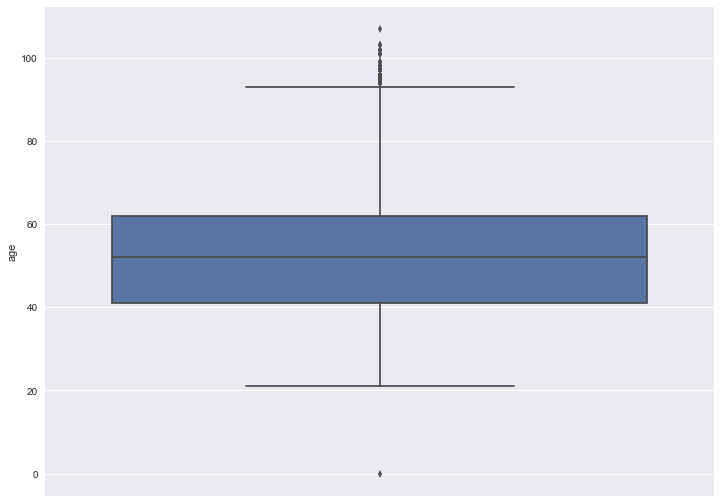

In [12]:
sns.set(rc={'figure.figsize':(12,9)})
sns.boxplot(y=data.age)

In [13]:
# 年龄等于0的异常值进行剔除
data = data[data['age'] > 0]

对于变量NumberOfTime3059DaysPastDueNotWorse、NumberOfTime6089DaysPastDueNotWorse、NumberOfTimes90DaysLate这三个变量，由下面的箱线图可以看出，均存在异常值，且由unique函数可以得知均存在96、98两个异常值，因此予以剔除。同时会发现剔除其中一个变量的96、98值，其他变量的96、98两个值也会相应被剔除。

In [14]:
np.unique(data.NumberOfTime3059DaysPastDueNotWorse), np.unique(data.NumberOfTime6089DaysPastDueNotWorse), np.unique(data.NumberOfTimes90DaysLate)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 96, 98],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 96, 98], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
        96, 98], dtype=int64))

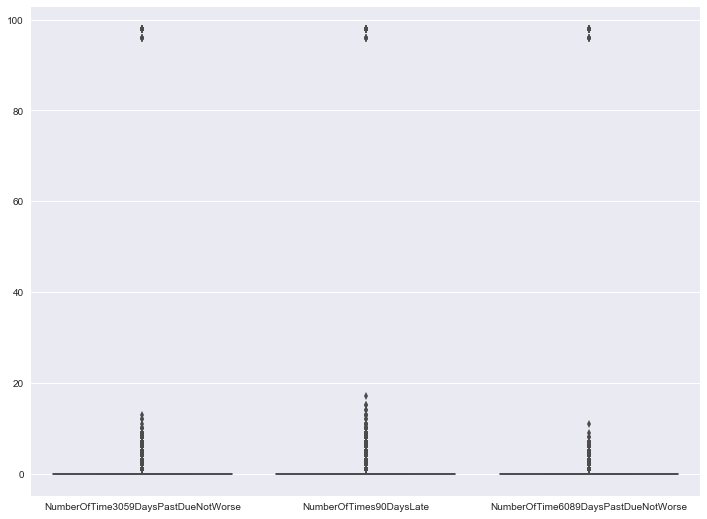

In [15]:
timeOuter = data.drop(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
        'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberRealEstateLoansOrLines',
       'NumberOfDependents'], 1)

sns.boxplot(data=timeOuter)

In [16]:
#剔除异常值
data = data[data['NumberOfTime3059DaysPastDueNotWorse'] < 90]

另外，数据集中好客户为0，违约客户为1，考虑到正常的理解，能正常履约并支付利息的客户为1，所以我们将其取反。m

In [17]:
data['SeriousDlqin2yrs']=1-data['SeriousDlqin2yrs']

#### 数据切分

为了验证模型的拟合效果，我们需要对数据集进行切分，分成训练集和测试集。

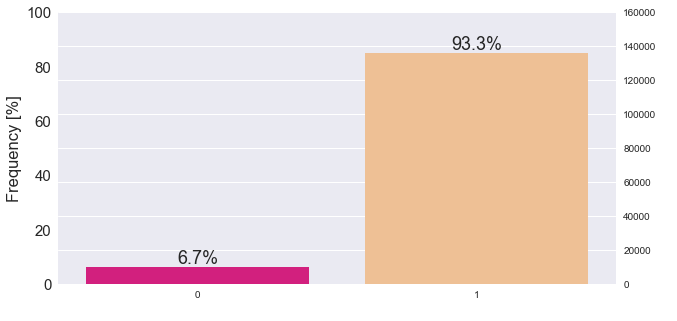

In [18]:
def add_freq():
    ncount = len(data)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)
    
ax = sns.countplot(x = data.SeriousDlqin2yrs ,palette="Accent_r")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

add_freq()

plt.show()

In [19]:
from sklearn.model_selection import train_test_split

X = data.drop('SeriousDlqin2yrs', axis=1)
Y = data.SeriousDlqin2yrs

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

train = pd.concat([Y_train, X_train], axis=1)
test = pd.concat([Y_test, X_test], axis=1)
classTest = test.groupby('SeriousDlqin2yrs')['SeriousDlqin2yrs'].count()

In [20]:
classTest, data.isnull().sum(), train.isnull().sum()

(SeriousDlqin2yrs
 0     2317
 1    34022
 Name: SeriousDlqin2yrs, dtype: int64,
 SeriousDlqin2yrs                        0
 RevolvingUtilizationOfUnsecuredLines    0
 age                                     0
 NumberOfTime3059DaysPastDueNotWorse     0
 DebtRatio                               0
 MonthlyIncome                           0
 NumberOfOpenCreditLinesAndLoans         0
 NumberOfTimes90DaysLate                 0
 NumberRealEstateLoansOrLines            0
 NumberOfTime6089DaysPastDueNotWorse     0
 NumberOfDependents                      0
 dtype: int64,
 SeriousDlqin2yrs                        0
 RevolvingUtilizationOfUnsecuredLines    0
 age                                     0
 NumberOfTime3059DaysPastDueNotWorse     0
 DebtRatio                               0
 MonthlyIncome                           0
 NumberOfOpenCreditLinesAndLoans         0
 NumberOfTimes90DaysLate                 0
 NumberRealEstateLoansOrLines            0
 NumberOfTime6089DaysPastDueNotWorse     0
 

### 3|探索性分析

在建立模型之前，我们一般会对现有的数据进行探索性数据分析**（Exploratory Data Analysis）** 。 EDA是指对已有的数据(特别是调查或观察得来的原始数据)在尽量少的先验假定下进行探索。常用的探索性数据分析方法有：直方图、散点图和箱线图等。
客户年龄分布如下图所示，可以看到年龄变量大致呈正态分布，符合统计分析的假设。

d:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


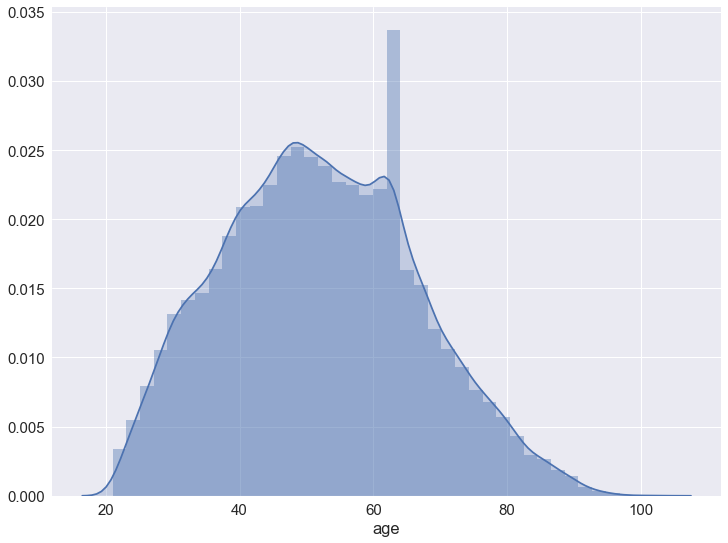

In [21]:
sns.distplot(train['age'], bins=40, kde_kws={"shade": True})

#### **分位数图示法（Quantile Quantile Plot，简称 Q-Q 图）**

统计学里Q-Q图（Q代表分位数）是一个概率图，用图形的方式比较两个概率分布，把他们的两个分位数放在一起比较。首先选好分位数间隔。图上的点（x,y）反映出其中一个第二个分布（y坐标）的分位数和与之对应的第一分布（x坐标）的相同分位数。因此，这条线是一条以分位数间隔为参数的曲线。如果两个分布相似，则该Q-Q图趋近于落在y=x线上。如果两分布线性相关，则点在Q-Q图上趋近于落在一条直线上，但不一定在y=x线上。Q-Q图可以用来可在分布的位置-尺度范畴上可视化的评估参数。

从定义中可以看出Q-Q图主要用于检验数据分布的相似性，如果要利用Q-Q图来对数据进行正态分布的检验，则可以令x轴为正态分布的分位数，y轴为样本分位数，如果这两者构成的点分布在一条直线上，就证明样本数据与正态分布存在线性相关性，即服从正态分布。
 

((array([-4.36492726, -4.16697223, -4.05933226, ...,  4.05933226,
          4.16697223,  4.36492726]),
  array([ 21,  21,  21, ..., 103, 103, 103], dtype=int64)),
 (14.484603012703554, 52.08555703343577, 0.9952373511970664))

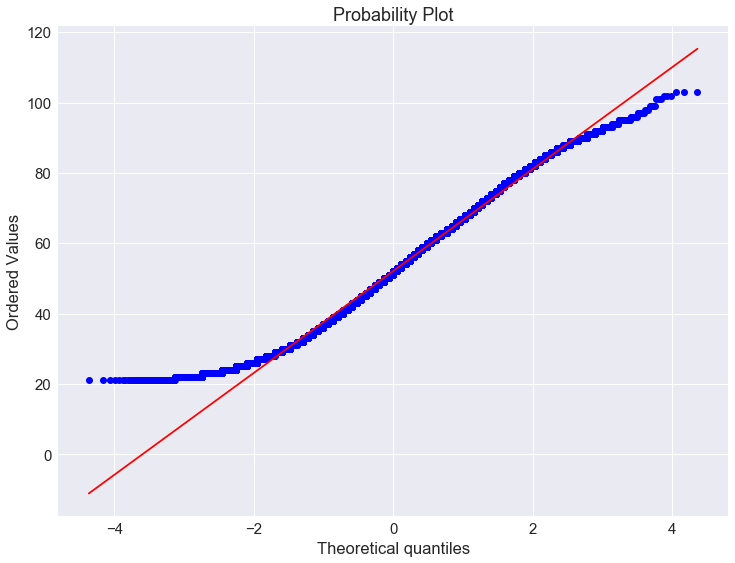

In [22]:
import scipy
from scipy import stats

stats.probplot(train['age'], plot=plt)

###  4| 变量选择

特征变量选择(排序)对于数据分析、机器学习从业者来说非常重要。好的特征选择能够提升模型的性能，更能帮助我们理解数据的特点、底层结构，这对进一步改善模型、算法都有着重要作用。

在本文中，我们采用信用评分模型的变量选择方法，通过WOE分析方法，即是通过比较指标分箱和对应分箱的违约概率来确定指标是否符合经济意义。首先我们对变量进行离散化（分箱）处理。

#### 变量分箱

变量分箱（binning）是对连续变量离散化（discretization）的一种称呼。信用评分卡开发中常用的有等距分段、等深分段、最优分段。
其中等距分段（Equval length intervals）是指分段的区间是一致的，比如年龄以十年作为一个分段；等深分段（Equal frequency intervals）
是先确定分段数量，然后令每个分段中数据数量大致相等；最优分段（Optimal Binning）又叫监督离散化（supervised discretizaion），
使用递归划分（Recursive Partitioning）将连续变量分为分段，背后是一种基于条件推断查找较佳分组的算法。

我们首先选择对连续变量进行最优分段，在连续变量的分布不满足最优分段的要求时，再考虑对连续变量进行等距分段。最优分箱的代码如下：

In [23]:
# 定义自动分箱函数
def mono_bin(Y, X, n = 20):
    r = 0
    good=Y.sum()
    bad=Y.count()-good
    while np.abs(r) < 1:
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n)})
        d2 = d1.groupby('Bucket', as_index = True)
        r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        n = n - 1
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
    d3['min']=d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe']=np.log((d3['rate']/(1-d3['rate']))/(good/bad))
    d3['goodattribute']=d3['sum']/good
    d3['badattribute']=(d3['total']-d3['sum'])/bad
    iv=((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum()
    d4 = (d3.sort_values(by = 'min'))
    print("=" * 60)
    print(d4)
    cut=[]
    cut.append(float('-inf'))
    for i in range(1,n+1):
        qua=X.quantile(i/(n+1))
        cut.append(round(qua,4))
    cut.append(float('inf'))
    woe=list(d4['woe'].round(3))
    return d4,iv,cut,woe

#自定义分箱函数
def self_bin(Y,X,cat):
    good=Y.sum()
    bad=Y.count()-good
    d1=pd.DataFrame({'X':X,'Y':Y,'Bucket':pd.cut(X,cat)})
    d2=d1.groupby('Bucket', as_index = True)
    d3 = pd.DataFrame(d2.X.min(), columns=['min'])
    d3['min'] = d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe'] = np.log((d3['rate'] / (1 - d3['rate'])) / (good / bad))
    d3['goodattribute'] = d3['sum'] / good
    d3['badattribute'] = (d3['total'] - d3['sum']) / bad
    iv = ((d3['goodattribute'] - d3['badattribute']) * d3['woe']).sum()
    d4 = (d3.sort_values(by='min'))
    print("=" * 60)
    print(d4)
    woe = list(d4['woe'].round(3))
    return d4, iv,woe

#计算分数函数
def get_score(coe,woe,factor):
    scores=[]
    for w in woe:
        score=round(coe*w*factor,0)
        scores.append(score)
    return scores

#根据变量计算分数
def compute_score(series,cut,score):
    items = []
    i = 0
    while i < len(series):
        value = series[i]
        j = len(cut) - 2
        m = len(cut) - 2
        while j >= 0:
            if value >= cut[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        items.append(score[m])
        i += 1
    return items

针对我们将使用最优分段对于数据集中的RevolvingUtilizationOfUnsecuredLines、age、DebtRatio和MonthlyIncome进行分类。

针对不能最优分箱的变量，分箱如下：

In [24]:
# 连续变量离散化
pinf = float('inf')#正无穷大
ninf = float('-inf')#负无穷大
cutx3 = [ninf, 0, 1, 3, 5, pinf]
cutx6 = [ninf, 1, 2, 3, 5, pinf]
cutx7 = [ninf, 0, 1, 3, 5, pinf]
cutx8 = [ninf, 0,1,2, 3, pinf]
cutx9 = [ninf, 0, 1, 3, pinf]
cutx10 = [ninf, 0, 1, 2, 3, 5, pinf]

In [25]:

dfx1, ivx1,cutx1,woex1=mono_bin(train.SeriousDlqin2yrs, train.RevolvingUtilizationOfUnsecuredLines,n=10)
dfx2, ivx2,cutx2,woex2=mono_bin(train.SeriousDlqin2yrs, train.age, n=10)
dfx4, ivx4,cutx4,woex4 =mono_bin(train.SeriousDlqin2yrs, train.DebtRatio, n=20)
dfx5, ivx5,cutx5,woex5 =mono_bin(train.SeriousDlqin2yrs, train.MonthlyIncome, n=10)
dfx3, ivx3,woex3 = self_bin(train.SeriousDlqin2yrs, train['NumberOfTime3059DaysPastDueNotWorse'], cutx3)
dfx6, ivx6 ,woex6= self_bin(train.SeriousDlqin2yrs, train['NumberOfOpenCreditLinesAndLoans'], cutx6)
dfx7, ivx7,woex7 = self_bin(train.SeriousDlqin2yrs, train['NumberOfTimes90DaysLate'], cutx7)
dfx8, ivx8,woex8 = self_bin(train.SeriousDlqin2yrs, train['NumberRealEstateLoansOrLines'], cutx8)
dfx9, ivx9,woex9 = self_bin(train.SeriousDlqin2yrs, train['NumberOfTime6089DaysPastDueNotWorse'], cutx9)
dfx10, ivx10,woex10 = self_bin(train.SeriousDlqin2yrs, train['NumberOfDependents'], cutx10)

                       min           max    sum  total      rate       woe  \
Bucket                                                                       
(-0.001, 0.0313]  0.000000      0.031301  26726  27255  0.980591  1.301097   
(0.0313, 0.159]   0.031303      0.158682  26688  27253  0.979268  1.233837   
(0.159, 0.561]    0.158684      0.561462  25878  27253  0.949547  0.313632   
(0.561, 29110.0]  0.561470  29110.000000  22334  27254  0.819476 -1.108505   

                  goodattribute  badattribute  
Bucket                                         
(-0.001, 0.0313]       0.262984      0.071593  
(0.0313, 0.159]        0.262610      0.076465  
(0.159, 0.561]         0.254640      0.186087  
(0.561, 29110.0]       0.219767      0.665855  
                min  max    sum  total      rate       woe  goodattribute  \
Bucket                                                                      
(20.999, 33.0]   21   33  10843  12209  0.888115 -0.549674       0.106695   
(33.0, 40.0]

#### WOE

WoE分析， 是对指标分箱、计算各个档位的WoE值并观察WoE值随指标变化的趋势。其中WoE的数学定义是:
woe=ln(goodattribute/badattribute)
在进行分析时，我们需要对各指标从小到大排列，并计算出相应分档的WoE值。其中正向指标越大，WoE值越小；反向指标越大，WoE值越大。正向指标的WoE值负斜率越大，反响指标的正斜率越大，则说明指标区分能力好。WoE值趋近于直线，则意味指标判断能力较弱。若正向指标和WoE正相关趋势、反向指标同WoE出现负相关趋势，则说明此指标不符合经济意义，则应当予以去除。

#### 相关性分析和IV筛选

接下来，我们会用经过清洗后的数据看一下变量间的相关性。注意，这里的相关性分析只是初步的检查，进一步检查模型的VI（证据权重）作为变量筛选的依据。
相关性图我们通过Python里面的seaborn包，调用heatmap()绘图函数进行绘制，实现代码如下：

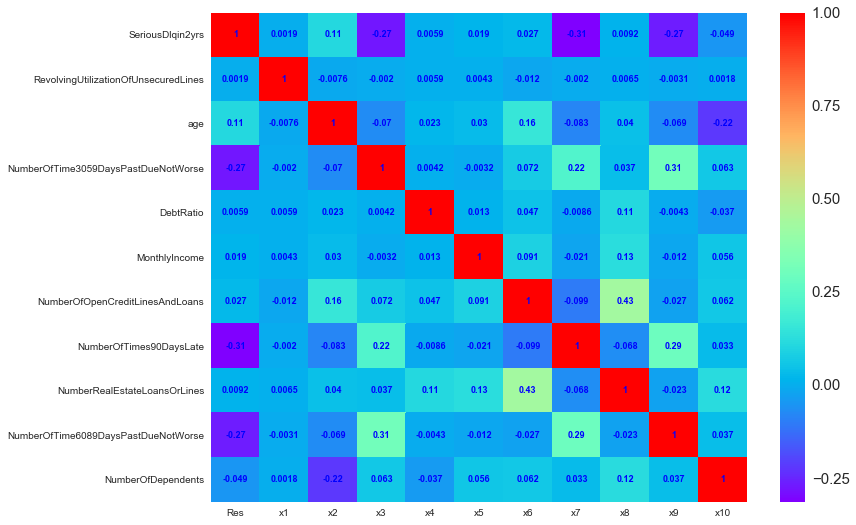

In [26]:
corr = train.corr()#计算各变量的相关性系数
xticks = ['Res','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']#x轴标签
yticks = list(corr.index)#y轴标签
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
sns.heatmap(corr, annot=True, cmap='rainbow', ax=ax1, annot_kws={'size': 9, 'weight': 'bold', 'color': 'blue'})#绘制相关性系数热力图
ax1.set_xticklabels(xticks, rotation=0, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

由上图可以看出，各变量之间的相关性是非常小的。NumberOfOpenCreditLinesAndLoans和NumberRealEstateLoansOrLines的相关性系数为0.43。
接下来，我进一步计算每个变量的Infomation Value（IV）。IV指标是一般用来确定自变量的预测能力。 其公式为：
IV=sum((goodattribute-badattribute)*ln(goodattribute/badattribute))

通过IV值判断变量预测能力的标准是：
- < 0.02: unpredictive
- 0.02 to 0.1: weak
- 0.1 to 0.3: medium
- 0.3 to 0.5: strong
- \> 0.5: suspicious

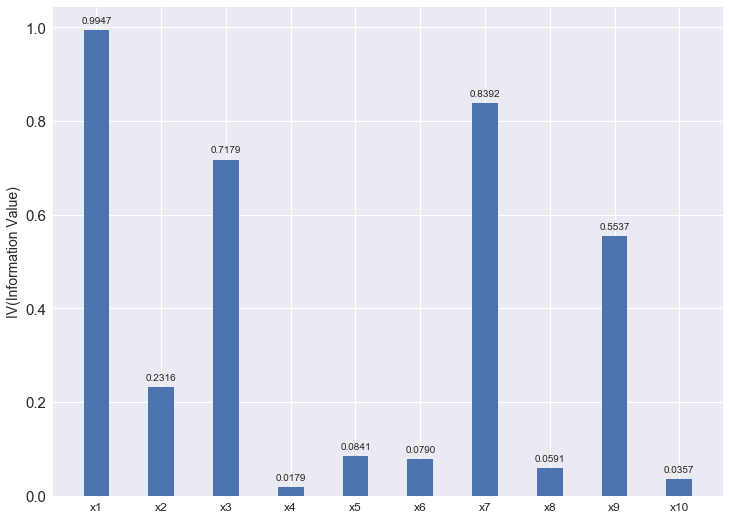

In [27]:
ivlist=[ivx1,ivx2,ivx3,ivx4,ivx5,ivx6,ivx7,ivx8,ivx9,ivx10]#各变量IV
index=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']#x轴的标签
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1, 1, 1)
x = np.arange(len(index))+1
ax1.bar(x, ivlist, width=0.4)#生成柱状图
ax1.set_xticks(x)
ax1.set_xticklabels(index, rotation=0, fontsize=12)
ax1.set_ylabel('IV(Information Value)', fontsize=14)
#在柱状图上添加数字标签
for a, b in zip(x, ivlist):
    plt.text(a, b + 0.01, '%.4f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

可以看出，DebtRatio、MonthlyIncome、NumberOfOpenCreditLinesAndLoans、NumberRealEstateLoansOrLines和NumberOfDependents变量的IV值明显较低，所以予以删除。

数据预处理主要针对缺失值用KNN最近邻法和直接剔除法进行处理，对于异常值主要根据实际情况和箱形图的数据分布，对异常值进行剔除；探索性分析主要对各变量的分布情况进行初始的探究；变量选择主要考虑了变量的分箱方法，根据分箱结果计算WOE值，然后检查变量之间的相关性，根据各变量的IV值来选择对数据处理有好效果的变量。


### 5| 模型分析
证据权重（Weight of Evidence,WOE）转换可以将Logistic回归模型转变为标准评分卡格式。引入WOE转换的目的并不是为了提高模型质量，只是一些变量不应该被纳入模型，这或者是因为它们不能增加模型值，或者是因为与其模型相关系数有关的误差较大，其实建立标准信用评分卡也可以不采用WOE转换。这种情况下，Logistic回归模型需要处理更大数量的自变量。尽管这样会增加建模程序的复杂性，但最终得到的评分卡都是一样的。
在建立模型之前，我们需要将筛选后的变量转换为WoE值，便于信用评分。


#### WOE转换

我们已经能获取了每个变量的分箱数据和woe数据，只需要根据各变量数据进行替换，实现代码如下：

In [28]:
def replace_woe(series,cut,woe):
    items=[]
    i=0
    series = list(series)
    lenseries = len(series)
    while i< lenseries:
#         print(1, list(series)[i])
        value=series[i]
        j=len(cut)-2
        m=len(cut)-2
        
        while j>=0:
            if value>=cut[j]:
                j=-1
            else:
                j -= 1
                m -= 1
        items.append(woe[m])
        i += 1
    return items

In [29]:
from pandas import Series
# 替换成woe
train['RevolvingUtilizationOfUnsecuredLines'] = Series(replace_woe(train['RevolvingUtilizationOfUnsecuredLines'], cutx1, woex1))
train['age'] = Series(replace_woe(train['age'], cutx2, woex2))
train['NumberOfTime3059DaysPastDueNotWorse'] = Series(replace_woe(train['NumberOfTime3059DaysPastDueNotWorse'], cutx3, woex3))
train['DebtRatio'] = Series(replace_woe(train['DebtRatio'], cutx4, woex4))
train['MonthlyIncome'] = Series(replace_woe(train['MonthlyIncome'], cutx5, woex5))
train['NumberOfOpenCreditLinesAndLoans'] = Series(replace_woe(train['NumberOfOpenCreditLinesAndLoans'], cutx6, woex6))
train['NumberOfTimes90DaysLate'] = Series(replace_woe(train['NumberOfTimes90DaysLate'], cutx7, woex7))
train['NumberRealEstateLoansOrLines'] = Series(replace_woe(train['NumberRealEstateLoansOrLines'], cutx8, woex8))
train['NumberOfTime6089DaysPastDueNotWorse'] = Series(replace_woe(train['NumberOfTime6089DaysPastDueNotWorse'], cutx9, woex9))
train['NumberOfDependents'] = Series(replace_woe(train['NumberOfDependents'], cutx10, woex10))

In [30]:
test['RevolvingUtilizationOfUnsecuredLines'] = Series(replace_woe(test['RevolvingUtilizationOfUnsecuredLines'], cutx1, woex1))
test['age'] = Series(replace_woe(test['age'], cutx2, woex2))
test['NumberOfTime3059DaysPastDueNotWorse'] = Series(replace_woe(test['NumberOfTime3059DaysPastDueNotWorse'], cutx3, woex3))
test['DebtRatio'] = Series(replace_woe(test['DebtRatio'], cutx4, woex4))
test['MonthlyIncome'] = Series(replace_woe(test['MonthlyIncome'], cutx5, woex5))
test['NumberOfOpenCreditLinesAndLoans'] = Series(replace_woe(test['NumberOfOpenCreditLinesAndLoans'], cutx6, woex6))
test['NumberOfTimes90DaysLate'] = Series(replace_woe(test['NumberOfTimes90DaysLate'], cutx7, woex7))
test['NumberRealEstateLoansOrLines'] = Series(replace_woe(test['NumberRealEstateLoansOrLines'], cutx8, woex8))
test['NumberOfTime6089DaysPastDueNotWorse'] = Series(replace_woe(test['NumberOfTime6089DaysPastDueNotWorse'], cutx9, woex9))
test['NumberOfDependents'] = Series(replace_woe(test['NumberOfDependents'], cutx10, woex10))

#### Logisic模型建立
我们直接调用statsmodels包来实现逻辑回归：

In [31]:
train = train.dropna()
test = test.dropna()

import statsmodels.api as sm
#应变量
Y=train['SeriousDlqin2yrs']
#自变量，剔除对因变量影响不明显的变量
X=train.drop(['SeriousDlqin2yrs','DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)

X1=sm.add_constant(X)
logit=sm.Logit(Y,X1)
result=logit.fit()
result.summary()

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.248001
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:                79301
Model:                          Logit   Df Residuals:                    79295
Method:                           MLE   Df Model:                            5
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:               8.797e-05
Time:                        19:54:50   Log-Likelihood:                -19667.
converged:                       True   LL-Null:                       -19668.
                                        LLR p-value:                    0.6294
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    2.4592      0.181     13.570      0.000       2.104       2.814
RevolvingUtilizationOfUnsecuredLines     0.0153      0.016      0.973      0.331      -0.016       0.046
age                                     -0.0192      0.027     -0.699      0.484      -0.073       0.035
NumberOfTime3059DaysPastDueNotWorse     -0.0577      0.044     -1.304      0.192      -0.144       0.029
NumberOfTimes90DaysLate                 -0.0051      0.075     -0.068      0.946      -0.153       0.142
NumberOfTime6089DaysPastDueNotWorse     -0.0460      0.081     -0.569      0.569      -0.205       0.112
========================================================================================================
"""

#### 模型检验
到这里，我们的建模部分基本结束了。我们需要验证一下模型的预测能力如何。我们使用在建模开始阶段预留的test数据进行检验。通过ROC曲线和AUC来评估模型的拟合能力。
在Python中，可以利用sklearn.metrics，它能方便比较两个分类器，自动计算ROC和AUC。

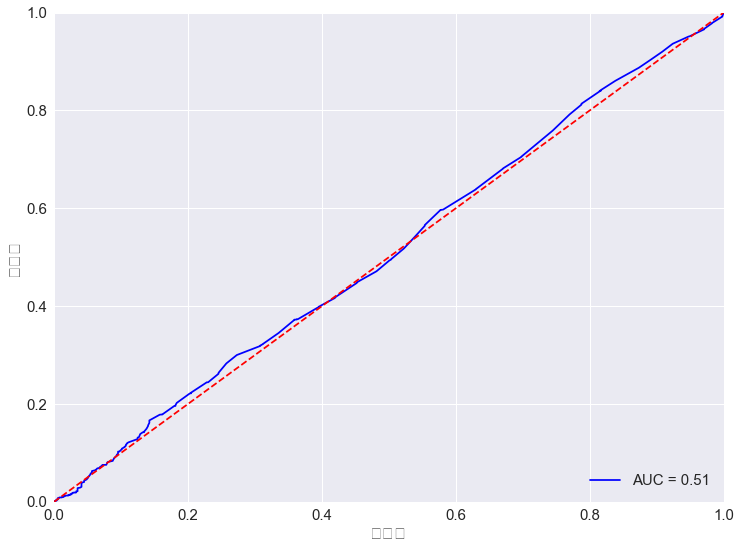

In [32]:
#应变量
Y_test = test['SeriousDlqin2yrs']
#自变量，剔除对因变量影响不明显的变量，与模型变量对应
X_test = test.drop(['SeriousDlqin2yrs', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines', 'NumberOfDependents'], axis=1)
X3 = sm.add_constant(X_test)
resu = result.predict(X3)#进行预测
fpr, tpr, threshold = roc_curve(Y_test, resu)
rocauc = auc(fpr, tpr)#计算AUC
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % rocauc)#生成ROC曲线
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('真正率')
plt.xlabel('假正率')
plt.show()
